# Exercise 2.4

Use the data and calculations from Exercise 1.7 and assume that the insurance company collects all the premiums at the beginning of the year. Consider a low-risk fixed 1-year interest rate of 5% and that the shareholders of the company expect a ROE (return on equity) of 12%. Assuming that deaths are uniformly distributed (probabilistically) throughout the year, using again 100,000 simulations of the portfolio, estimate quantiles 2.5%, 25%, 50% (median), 75%, and 97.5\% of the ROE, and the probability $\mathbb{P}(\text{ROE}\geq 12\%),$ under each of the following premium principles:
1. Expected value principle.
2. Variance principle.
3. Using formula from Exercise 2.3

## Upload and prepare data

In [1]:
using Distributions, Statistics, Plots, CSV, DataFrames, Dates

In [2]:
mort = DataFrame(CSV.File("mortality.csv")) # mortality table
policy = DataFrame(CSV.File("LIFEinsurance.csv")); # insurance policies

Theoretical mean and variance for total claims: $\mathbb{E}(S)$ and $\mathbb{V}(S).$ Add to DataFrame `policy` columns for $\mathbb{E}(X_j),$ $\mathbb{V}(X_j)$ and $\mathbb{D}(X_j)=\mathbb{E}(\max\{X_j - \mathbb{E}(X_j), 0\}).$

In [3]:
n = length(policy.AGE) # number of insurance policies
k = 1/10 # probability of accident given death
q = Dict(mort.AGE .=> mort.qx) # mapping age -> qx
policy.EX = zeros(n)
policy.VX = zeros(n)
policy.DX = zeros(n)
ES, VS = 0.0, 0.0
for j ∈ 1:n
    qj = q[policy.AGE[j]]
    cj = policy.INSAMOUNT[j]
    policy.EX[j] = (1 + k)*cj*qj
    ES += policy.EX[j]
    policy.VX[j] = qj*(1-qj)*((1+k)*cj)^2 + qj*(1-k)k*(cj^2)
    VS += policy.VX[j] # assuming independence
    policy.DX[j] = sum(max.((0, cj, 2cj) .- policy.EX[j], 0) .* (1 - qj, qj * (1 - k), qj * k))
end
println("E(S) = ", ES)
println("V(S) = ", VS)
policy[1:5, :]
size(policy)

E(S) = 345.3497998500011
V(S) = 4202.942121519234


(10000, 5)

In [4]:
policy[1:5, :]

Row,AGE,INSAMOUNT,EX,VX,DX
,Int64,Float64,Float64,Float64,Float64
1,49,9.2,0.039468,0.427567,0.0393141
2,26,3.1,0.00567765,0.0207686,0.0056682
3,59,10.7,0.0777997,0.97776,0.0772854
4,46,12.6,0.0469854,0.697448,0.0468261
5,30,5.1,0.0104627,0.0629518,0.0104431


Approximate median and 99.5% Value at Risk for total claims: $\mathbb{M}(S)$ and $\text{VaR}_{0.995}(S)$

In [5]:
m = 100_000
n = length(policy.AGE) # number of insurance policies
S = zeros(m)
begin
    Death = zeros(Bool, m, n) 
    Accident = rand(Bernoulli(k), m, n)
    for j ∈ 1:n
        Death[:, j] = rand(Bernoulli(q[policy.AGE[j]]), m)
    end
    for i ∈ 1:m
        S[i] = sum(policy.INSAMOUNT .* Death[i, :] .* (1 .+ Accident[i, :]))
    end
end

In [6]:
Death = 0; Accident = 0; # release memory

In [7]:
MS = median(S)
VaR = quantile(S, 0.995)
println("M(S) = ", MS)
println("99.5% VaR = ", VaR)

M(S) = 342.3
99.5% VaR = 525.3


Solvency Capital Requirement, based on the expected value and the median: $\text{SCRe}(S)$ and $\text{SCRm}(S)$

In [8]:
SCRe = VaR - ES # based on expected value
SCRm = VaR - MS # based on the median
println("SCRe(S) = ", SCRe)
println("SCRm(S) = ", SCRm)

SCRe(S) = 179.95020014999886
SCRm(S) = 182.99999999999994


Risk Margin, based on the expected value and the median: $\text{RMe}(S)$ and $\text{RMm}(S)$

In [9]:
r = 0.12 # shareholders' return rate
i = 0.05; # low-risk return rate
RMe = (r - i) * SCRe # based on expected value
RMm = (r - i) * SCRm # based on the median
println("RMe(S) = ", RMe)
println("RMm(S) = ", RMm)

RMe(S) = 12.59651401049992
RMm(S) = 12.809999999999995


## Premiums

**Expected value principle**

In [10]:
θE = RMe / ES

0.03647465270277

In [11]:
policy.PErisk = policy.EX
policy.PEmargin = θE .* policy.EX
policy.PE = policy.PErisk .+ policy.PEmargin
policy[1:5, :]
size(policy)

(10000, 8)

In [12]:
policy[1:3, :]

Row,AGE,INSAMOUNT,EX,VX,DX,PErisk,PEmargin,PE
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,49,9.2,0.039468,0.427567,0.0393141,0.039468,0.00143958,0.0409076
2,26,3.1,0.00567765,0.0207686,0.0056682,0.00567765,0.00020709,0.00588474
3,59,10.7,0.0777997,0.97776,0.0772854,0.0777997,0.00283772,0.0806374


In [13]:
sum(policy.PE), ES + RMe # checking the sum of total premiums

(357.9463138604999, 357.946313860501)

**Variance principle** 

In [14]:
θV = RMe / VS

0.002997070539231377

In [15]:
policy.PVrisk = policy.EX
policy.PVmargin = θV .* policy.VX
policy.PV = policy.PVrisk .+ policy.PVmargin
size(policy)

(10000, 11)

In [16]:
policy[1:3, 6:11]

Row,PErisk,PEmargin,PE,PVrisk,PVmargin,PV
,Float64,Float64,Float64,Float64,Float64,Float64
1,0.039468,0.00143958,0.0409076,0.039468,0.00128145,0.0407494
2,0.00567765,0.00020709,0.00588474,0.00567765,6.2245e-5,0.00573989
3,0.0777997,0.00283772,0.0806374,0.0777997,0.00293042,0.0807301


In [17]:
sum(policy.PV), ES + RMe # checking the sum of total premiums

(357.94631386049997, 357.946313860501)

Comparing against the expected value principle:

In [18]:
PEPV = policy.PE ./ policy.PV
quantile(PEPV, [0.025, 0.5, 0.975])

3-element Vector{Float64}:
 0.9857628073397737
 1.0080106225813403
 1.0313675300898781

In [19]:
mean(PEPV)

1.0075542340752008

As expected, individual premiums based on the expected value principle are higher (on average and median) that those based in the variance principle, since the expected value principle is not consistent and loads the risk premium more than it should.

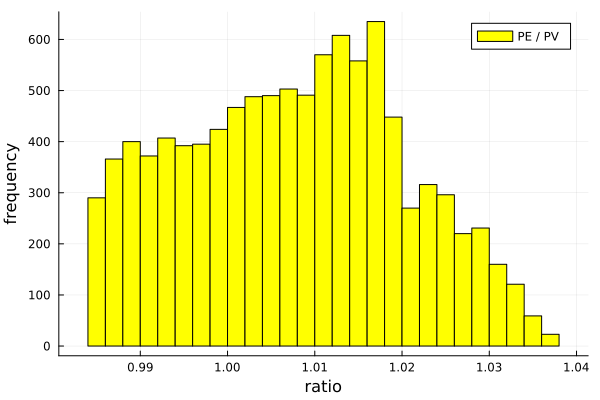

In [20]:
histogram(PEPV, label = "PE / PV", xlabel = "ratio", ylabel = "frequency", color = :yellow)

**Exercise 2.3 formula**

In [21]:
sD = sum(policy.DX)
policy.PDrisk = (MS / ES) .* policy.EX
policy.PDmargin = (RMm / sD) .* policy.DX
policy.PD = policy.PDrisk .+ policy.PDmargin
size(policy)

(10000, 14)

In [22]:
policy[1:3, 9:14]

Row,PVrisk,PVmargin,PV,PDrisk,PDmargin,PD
,Float64,Float64,Float64,Float64,Float64,Float64
1,0.039468,0.00128145,0.0407494,0.0391195,0.00146541,0.0405849
2,0.00567765,6.2245e-5,0.00573989,0.00562751,0.000211279,0.00583879
3,0.0777997,0.00293042,0.0807301,0.0771126,0.00288077,0.0799934


In [23]:
sum(policy.PD), MS + RMm # checking the sum of total premiums

(355.109999999999, 355.11)

Comparing against the variance principle:

In [24]:
PDPV = policy.PD ./ policy.PV
quantile(PDPV, [0.025, 0.5, 0.975])

3-element Vector{Float64}:
 0.9779264666508345
 1.000073562266178
 1.023320908691866

In [25]:
mean(PDPV)

0.9996220670850966

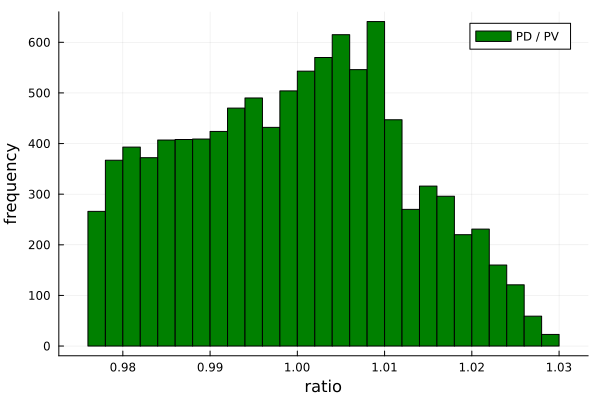

In [26]:
histogram(PDPV, label = "PD / PV", xlabel = "ratio", ylabel = "frequency", color = :green)

## Simulation

**Claims**

In [27]:
function simulateClaims() # from each insurance policy
    n = length(policy.AGE)
    k = 1/10 # probability of accident given death
    Death = zeros(n) 
    Accident = rand(Bernoulli(k), n)
    Claim = zeros(n)
    for j ∈ 1:n
        Death[j] = rand(Bernoulli(q[policy.AGE[j]]), 1)[1]
        Claim[j] = policy.INSAMOUNT[j] * Death[j] * (1 + Accident[j])
    end
    return Claim # vector of each policy claim (if any)
end

simulateClaims (generic function with 1 method)

In [28]:
ES, VaR, sum(simulateClaims()) # try several times just to see

(345.3497998500011, 525.3, 270.9)

**Accounting**

In [29]:
function simulateAcc(premiumPrinciple::String) 
    # "E" = expected value | "V" = variance | "D" = Exercise 2.3
    # Liabilities
    BEL = zeros(367); RM = zeros(367); L = zeros(367)
    # Assets: AR (reserves -> rate i), AF (free -> r)
    AR = zeros(367); AF = zeros(367); A = zeros(367) 
    # Capital
    SCR = zeros(367); K = zeros(367) 
    # [1] -> starting values | [2:366] -> 365 days of the year | [367] -> closing of the year
    if premiumPrinciple ∈ ["E", "V"]
        BEL[1] = ES; RM[1] = RMe; SCR[1] = SCRe
    elseif premiumPrinciple == "D"
        BEL[1] = MS; RM[1] = RMm; SCR[1] = SCRm
    else
        println("Unknown premium principle, try again!")
        return nothing
    end
    # starting Balance Sheet:
    L[1] = BEL[1] + RM[1]
    K[1] = SCR[1]
    AR[1] = L[1] + SCR[1]; AF[1] = 0; A[1] = AR[1] + AF[1]
    # claims of the year:
    claims = simulateClaims() # from each insurance policy
    idClaims = findall(a -> a > 0, claims) # policies with positive claims
    n = length(claims) # number of insurance policies in portfolio
    dayClaim = rand(DiscreteUniform(2, 366), n) # uniform distribution of claims during the year
    C = zeros(367) # to allocate total claims amount per day
    # equivalent daily rates:
    ii = (1 + i)^(1/365) - 1 # equivalent daily rate
    rr = (1 + r)^(1/365) - 1 # equivalent daily rate
    # simulate daily accounting:
    for d ∈ 2:366
        policies = findall(j -> j == d, dayClaim) ∩ idClaims
        C[d] = sum(claims[policies])
        BEL[d] = max(0, BEL[d-1] - C[d]) # until we run out of BEL
        RM[d] = max(0, RM[d-1] + min(0, BEL[d-1] - C[d])) # until we run out of RM (after BEL)
        L[d] = BEL[d] + RM[d]
        SCR[d] = max(0, SCR[d-1] + min(0, BEL[d-1] + RM[d-1] - C[d])) # until we run out of SCR (after RM)
        A[d] = (1 + ii)*AR[d-1] + (1 + rr)*AF[d-1] - C[d]
        AR[d] = L[d] + SCR[d]
        AF[d] = A[d] - AR[d]
        K[d] = A[d] - L[d]
    end
    # closing of the year:
    K[367] = K[366] + BEL[366] + RM[366] # kill remaining BEL and RM (if any)
    AR[367] = 0; AF[367] = A[366]; A[367] = A[366] # all assets become free
    C[367] = sum(C[2:366]) # total claims paid
    results = (C = C, AR = AR, AF = AF, A = A, BEL = BEL, RM = RM, L = L, SCR = SCR, K = K)
    return results
end

simulateAcc (generic function with 1 method)

For example:

In [30]:
s = simulateAcc("D")
# 366 -> end of year | 367 -> closing of the year
y = [1, 366, 367]
df = DataFrame(C = s.C[y], AR = s.AR[y], AF = s.AF[y], A = s.A[y], BEL = s.BEL[y],
               RM = s.RM[y], L = s.L[y], SCR = s.SCR[y], K = s.K[y]
)

Row,C,AR,AF,A,BEL,RM,L,SCR,K
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,538.11,0.0,538.11,342.3,12.81,355.11,183.0,183.0
2,0.0,296.91,21.679,318.589,101.1,12.81,113.91,183.0,204.679
3,241.2,0.0,318.589,318.589,0.0,0.0,0.0,0.0,318.589


In [31]:
print("Total claims paid = ", round(s.C[367], digits = 2))
println("   versus point estimate = ", round(s.BEL[1], digits = 2))
println("Return on Equity (ROE) = ", round(100 * (s.K[367] / s.K[1] - 1), digits = 2), "%")

Total claims paid = 241.2   versus point estimate = 342.3
Return on Equity (ROE) = 74.09%


**Return on Equity (ROE)**

In [32]:
function simulateROE(premiumPrinciple::String, numsims = 100_000)
    if premiumPrinciple ∉ ["E", "V", "D"]
        println("Premium principle must be E, V, or D. Try again!")
        return nothing
    end
    ROE = zeros(numsims)
    for j ∈ 1:numsims
        s = simulateAcc(premiumPrinciple)
        ROE[j] = 100 * (s.K[367] / s.K[1] - 1)
    end
    return ROE
end

simulateROE (generic function with 2 methods)

Under the expected value principle:

In [33]:
ROE_E = simulateROE("E", 10_000); # aprox 1:30 min 

In [34]:
quantile(ROE_E, [0.025, 0.25, 0.50, 0.75, 0.975])

5-element Vector{Float64}:
 -56.84339595398201
  -6.487021380581103
  19.199640511023787
  43.16311644879862
  85.67054298478912

In [35]:
println("P(ROE_E ≥ 12%) ≈ ", mean(ROE_E .≥ 12)) 
println("P(insolvency) = P(ROE_E < -100%) ≈ ", mean(ROE_E .< -100))

P(ROE_E ≥ 12%) ≈ 0.5775
P(insolvency) = P(ROE_E < -100%) ≈ 0.002


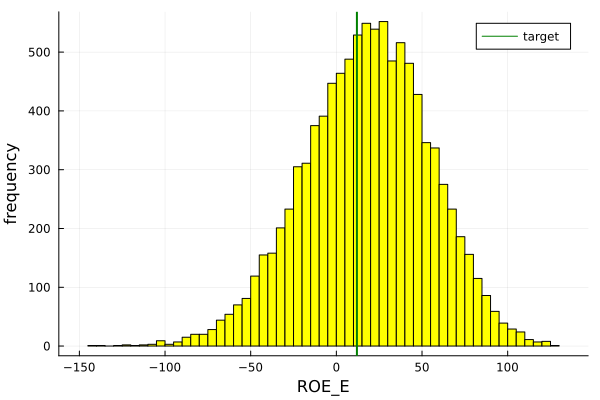

In [36]:
histogram(ROE_E, color = :yellow, label = "", xlabel = "ROE_E", ylabel = "frequency")
vline!([12], color = :green, lw = 2, label = "target")

Under the variance principle:

In [37]:
ROE_V = simulateROE("V", 10_000); # approx 1:20 min 

In [38]:
quantile(ROE_V, [0.025, 0.25, 0.50, 0.75, 0.975])

5-element Vector{Float64}:
 -57.18331599239621
  -5.905121279858877
  18.989646177095885
  43.20096887298921
  85.5686011596309

In [39]:
println("P(ROE_V ≥ 12%) ≈ ", mean(ROE_V .≥ 12)) 
println("P(insolvency) = P(ROE_V < -100%) ≈ ", mean(ROE_V .< -100))

P(ROE_V ≥ 12%) ≈ 0.575
P(insolvency) = P(ROE_V < -100%) ≈ 0.0014


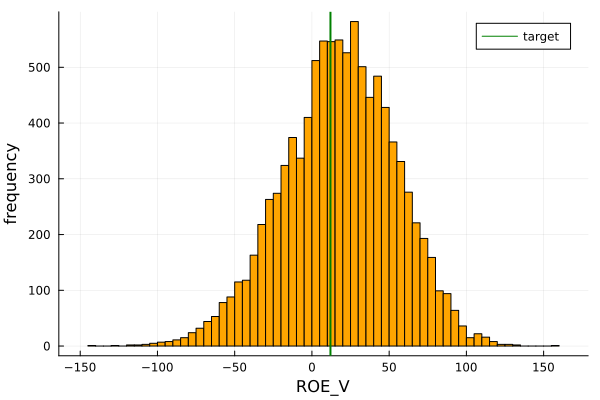

In [40]:
histogram(ROE_V, color = :orange, label = "", xlabel = "ROE_V", ylabel = "frequency")
vline!([12], color = :green, lw = 2, label = "target")

Under Exercise 2.3 formula:

In [41]:
ROE_D = simulateROE("D", 10_000); # approx 1:20 min 

In [42]:
quantile(ROE_D, [0.025, 0.25, 0.50, 0.75, 0.975])

5-element Vector{Float64}:
 -60.89543110675931
  -7.759670446984981
  17.278656835227547
  40.79563958194926
  83.36765288877743

In [43]:
println("P(ROE_D ≥ 12%) ≈ ", mean(ROE_D .≥ 12)) 
println("P(insolvency) = P(ROE_D < -100%) ≈ ", mean(ROE_D .< -100))

P(ROE_D ≥ 12%) ≈ 0.5626
P(insolvency) = P(ROE_D < -100%) ≈ 0.0016


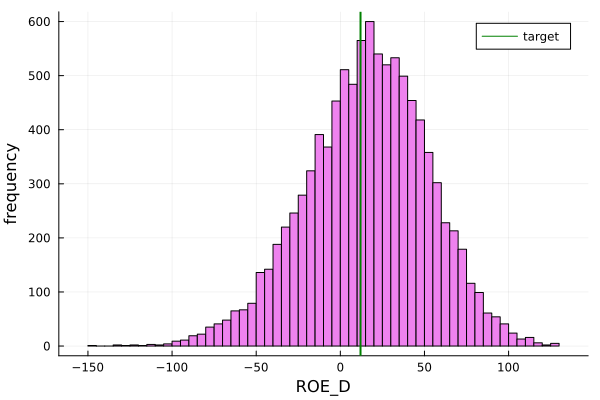

In [44]:
histogram(ROE_D, color = :violet, label = "", xlabel = "ROE_D", ylabel = "frequency")
vline!([12], color = :green, lw = 2, label = "target")